# Libraries

In [2]:
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [262]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from tqdm import tqdm
tqdm.pandas()

import mplfinance as mpf


# Helpful methods

In [232]:
def get_daily_df(minute_df, agg_dict):
    df_daily = resample_df(minute_df, "D", agg_dict)
    return df_daily


def get_hourly_df(minute_df, agg_dict):
    df_hourly = resample_df(minute_df, "H", agg_dict)
    df_hourly["hour"] = df_hourly["datetime"].dt.hour
    return df_hourly


def get_five_minute_df(minute_df, agg_dict):
    df_five_minute = resample_df(minute_df, "5T", agg_dict)
    return df_five_minute


def resample_df(df, resample_period, agg_dict):
    resampled_df = df.groupby("ticker").resample(resample_period).agg(agg_dict).dropna()
    resampled_df["ticker"] = resampled_df.index.get_level_values(0)
    resampled_df["datetime"] = resampled_df.index.get_level_values(1)
    resampled_df = resampled_df.reset_index(drop=True)
    resampled_df["date"] = resampled_df["datetime"].dt.date
    return resampled_df


# Loading out main dataset

In [125]:
# train_df = pd.read_csv("./train_beta.csv")
all_df = pd.read_csv("../data/US/1m/sp500/ALL.csv")
print(all_df.shape)
all_df.head()

(37745224, 7)


,date,open,high,low,close,volume,ticker
0,2024-01-02 09:30:00,1592.79,1592.79,1592.79,1592.79,559.0,TPL
1,2024-01-02 10:55:00,1618.76,1618.76,1618.76,1618.76,139.0,TPL
2,2024-01-02 11:05:00,1617.02,1617.02,1617.02,1617.02,753.0,TPL
3,2024-01-02 11:08:00,1619.00,1619.00,1619.00,1619.00,467.0,TPL
4,2024-01-02 11:19:00,1623.97,1623.97,1623.97,1623.97,632.0,TPL


# Filtering Election Day

In [128]:
daily_variations = pd.read_csv("../data/US/processed/daily_variations.csv")
election_day = daily_variations.loc[daily_variations["date_only"] == "2024-11-06"]
election_day.head()

,date_only,ticker,open,close,prev_close,variation
213,2024-11-06,A,143.00,137.75,140.45,1.815593
428,2024-11-06,AAPL,222.61,222.70,223.46,-0.380381
643,2024-11-06,ABBV,205.79,201.18,201.69,2.032823
858,2024-11-06,ABNB,141.98,140.93,137.78,3.048338
1073,2024-11-06,ABT,121.00,116.78,117.68,2.821210


# Selecting top 20 positive and negative stocks on election day

In [130]:
top_20_positive = (
    election_day.groupby("ticker")["variation"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)
print(top_20_positive)

ticker
CRL     21.267807
DFS     16.617250
COF     14.591112
WFC     14.406118
NUE     13.877749
SYF     13.657163
TSLA    13.188867
CVS     11.492591
HUM     11.274679
MS       9.884609
STLD     9.456770
HWM      8.733967
URI      8.046366
AMP      7.714002
GS       7.661359
HBAN     7.652733
RJF      7.526294
EMR      7.469409
C        7.395195
KEY      7.064273
Name: variation, dtype: float64


In [131]:
top_20_negative = (
    election_day.groupby("ticker")["variation"]
    .mean()
    .sort_values(ascending=True)
    .head(20)
)
print(top_20_negative)

ticker
SMCI   -24.575352
ENPH   -14.196776
FSLR   -12.700838
MOH     -7.507724
CNC     -7.407407
UHS     -6.714131
AMT     -6.102408
DHI     -5.632502
NEE     -5.542843
AES     -5.351386
LEN     -5.172608
SBAC    -5.121128
PHM     -5.019508
HCA     -4.815632
EXPD    -4.581967
BLDR    -4.319726
BBY     -4.276174
IFF     -4.156997
DLTR    -3.953279
NEM     -3.825255
Name: variation, dtype: float64


In [133]:
# Combine the tickers
selected_tickers = list(set(top_20_positive.index) | set(top_20_negative.index))

# For simplicity let's work only with those 40 stocks

In [135]:
df = all_df.loc[all_df["ticker"].isin(selected_tickers)]
print(df.shape)
df.head()

(3124884, 7)


,date,open,high,low,close,volume,ticker
578195,2024-01-02 09:30:00,28.00000,28.00000,27.860,27.93425,512470.0,SMCI
578196,2024-01-02 09:31:00,27.87700,28.04200,27.877,28.00500,64890.0,SMCI
578197,2024-01-02 09:32:00,28.06000,28.23000,28.040,28.23000,242630.0,SMCI
578198,2024-01-02 09:33:00,28.29975,28.29975,28.008,28.02600,79920.0,SMCI
578199,2024-01-02 09:34:00,28.00200,28.10000,27.950,27.95000,110790.0,SMCI


# More preprocessing

- EMA (Exponential Moving Average) is a type of moving average that gives more weight to recent price data. 

- SMA (Simple Moving Average) is a type of moving average that gives equal weight to all price data in the lookback period.

In [137]:
# EMA (Exponential Moving Average) is a type of moving average that gives more weight to recent price data. 
# For one-minute bars, a common lookback period is 45 minutes, which is equivalent to 9 * 5 minutes.
ema_one_minute_bars = 9 * 5

# SMA (Simple Moving Average) is a type of moving average that gives equal weight to all price data in the lookback period.
# For daily bars, a common lookback period is 50 days.
sma_daily_bars = 50

In [138]:
df["EMA"] = df.groupby(["ticker", "date"])["close"].transform(
    lambda x: x.ewm(span=ema_one_minute_bars).mean()
)

In [144]:
df_backup = df.copy()

In [140]:
df.head()

,date,open,high,low,close,volume,ticker,EMA
578195,2024-01-02 09:30:00,28.00000,28.00000,27.860,27.93425,512470.0,SMCI,27.93425
578196,2024-01-02 09:31:00,27.87700,28.04200,27.877,28.00500,64890.0,SMCI,28.00500
578197,2024-01-02 09:32:00,28.06000,28.23000,28.040,28.23000,242630.0,SMCI,28.23000
578198,2024-01-02 09:33:00,28.29975,28.29975,28.008,28.02600,79920.0,SMCI,28.02600
578199,2024-01-02 09:34:00,28.00200,28.10000,27.950,27.95000,110790.0,SMCI,27.95000


In [283]:
df["date"] = pd.to_datetime(df["date"])

df_daily = get_daily_df(
    df.set_index(["date"]),
    {"open": "first", "high": "max", "low": "min", "close": "last"}
)  # we take the first close of each day to not "leak" future data into the minute bars

df_daily["SMA"] = df_daily.groupby("ticker")["close"].transform(
    lambda x: x.rolling(window=sma_daily_bars, min_periods=1).mean()
)  # very important to take the rolling moving average on the daily bars to avoid data leakage from future prices into current ones

df_daily.head()

,open,high,low,close,ticker,datetime,date,SMA
0,19.14,19.53,19.000,19.35,AES,2024-01-02,2024-01-02,19.3500
1,19.11,19.16,18.570,18.93,AES,2024-01-03,2024-01-03,19.1400
2,19.09,19.13,18.745,18.87,AES,2024-01-04,2024-01-04,19.0500
3,18.80,19.35,18.630,18.80,AES,2024-01-05,2024-01-05,18.9875
4,18.69,19.24,18.690,19.07,AES,2024-01-08,2024-01-08,19.0040


In [152]:
# Let's add SMA into our df 
df["date_only"] = df["date"].dt.date  # Extract date from datetime
df = df.merge(
    df_daily[["ticker", "date", "SMA"]], 
    how="left",
    left_on=["ticker", "date_only"],
    right_on=["ticker", "date"]
)

# Clean up: drop the temporary date_only column and the extra date column from merge
df = df.drop(columns=["date_only", "date_y"])
df = df.rename(columns={"date_x": "date"})

# Verify the result
print("\nShape of merged dataframe:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()


Shape of merged dataframe: (3124884, 9)

Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'ticker', 'EMA', 'SMA']


,date,open,high,low,close,volume,ticker,EMA,SMA
0,2024-01-02 09:30:00,28.00000,28.00000,27.860,27.93425,512470.0,SMCI,27.93425,27.93425
1,2024-01-02 09:31:00,27.87700,28.04200,27.877,28.00500,64890.0,SMCI,28.00500,27.93425
2,2024-01-02 09:32:00,28.06000,28.23000,28.040,28.23000,242630.0,SMCI,28.23000,27.93425
3,2024-01-02 09:33:00,28.29975,28.29975,28.008,28.02600,79920.0,SMCI,28.02600,27.93425
4,2024-01-02 09:34:00,28.00200,28.10000,27.950,27.95000,110790.0,SMCI,27.95000,27.93425


In [259]:
def plot_bars_with_indicators(
    ohlc, 
    ax, 
    title: str, 
    addplots=[], 
    ref_time="", 
    annotation=False,
):
    # Get the last row of data for annotations
    last = ohlc.iloc[-1]

    # Create the text for annotation
    text = (
        "ELECTION DAY\n"
        + f" {last.name.date().strftime('%Y-%m-%d')}\n"
        + f"O: {last['open']:.2f}\n"
        + f"H: {last['high']:.2f}\n"
        + f"L: {last['low']:.2f}\n"
        + f"C: {last['close']:.2f}\n"
        + f"SMA: {last['SMA']:.2f}"
        if "SMA" in ohlc.columns
        else ""
    )

    # Plot the candlestick chart
    if ref_time == "":
        mpf.plot(
            ohlc.rename(
                {"open": "Open", "high": "High", "low": "Low", "close": "Close"}, axis=1
            ),
            type="candle",
            ax=ax,
            addplot=addplots,
            axtitle=title,
            ylabel="Price",
            style="yahoo",
            datetime_format="%Y-%m-%d",
        )
    else:
        mpf.plot(
            ohlc.rename(
                {"open": "Open", "high": "High", "low": "Low", "close": "Close"}, axis=1
            ),
            type="candle",
            ax=ax,
            addplot=addplots,
            axtitle=title,
            ylabel="Price",
            vlines=dict(vlines=ref_time, linewidths=20, alpha=0.2),
            style="yahoo",
            datetime_format="%Y-%m-%d",
        )

    if annotation:
        # Add annotation
        ax.annotate(
            text,
            xy=(len(ohlc), last["close"]),
            textcoords="axes fraction",
            xytext=(1.05, 0.4),  # Position of the text box
            bbox=dict(boxstyle="round", fc="lightgray", alpha=0.8),
            arrowprops=dict(facecolor="black", width=1, alpha=0.5),
        )


def plot_ticker(ticker = "TSLA"):
    # Filter ticker data
    df_ticker = df[df["ticker"] == ticker]
    df_ticker.set_index("date", inplace=True)
    df_ticker = df_ticker[df_ticker.index >= "2024-08-01"]
    df_ticker = df_ticker[df_ticker.index <= "2024-11-07"]
    
    # Get ticker daily data
    df_ticker_daily = get_daily_df(
    df_ticker, {"open": "first", "high": "max", "low": "min", "close": "last", "SMA": "mean"}
)
    df_ticker_daily["date"] = pd.to_datetime(df_ticker_daily["date"])
    df_ticker_daily.set_index("date", inplace=True)
    
    # Get ticker data for election day
    election_day = "2024-11-06"
    df_ticker_election_day = df_ticker[
        (df_ticker.index.strftime('%Y-%m-%d') == election_day)
    ]
    
    fig, (ax_daily, ax_minute) = plt.subplots(1, 2, figsize=(20, 8))

    daily_addplot = mpf.make_addplot(
        df_ticker_daily["SMA"], panel=0, color="orange", ax=ax_daily
    )
    minute_addplot = mpf.make_addplot(
        df_ticker_election_day["EMA"], panel=0, color="orange", ax=ax_minute
    )
    plot_bars_with_indicators(
        df_ticker_daily,
        ax_daily,
        title=f"{ticker} Daily bars with SMA",
        addplots=[daily_addplot],
        annotation=True,
    )

    plot_bars_with_indicators(
        df_ticker_election_day,
        ax_minute,
        title=f"{ticker} Election Day of Trading with EMA",
        addplots=[minute_addplot],
    )
    plt.show()

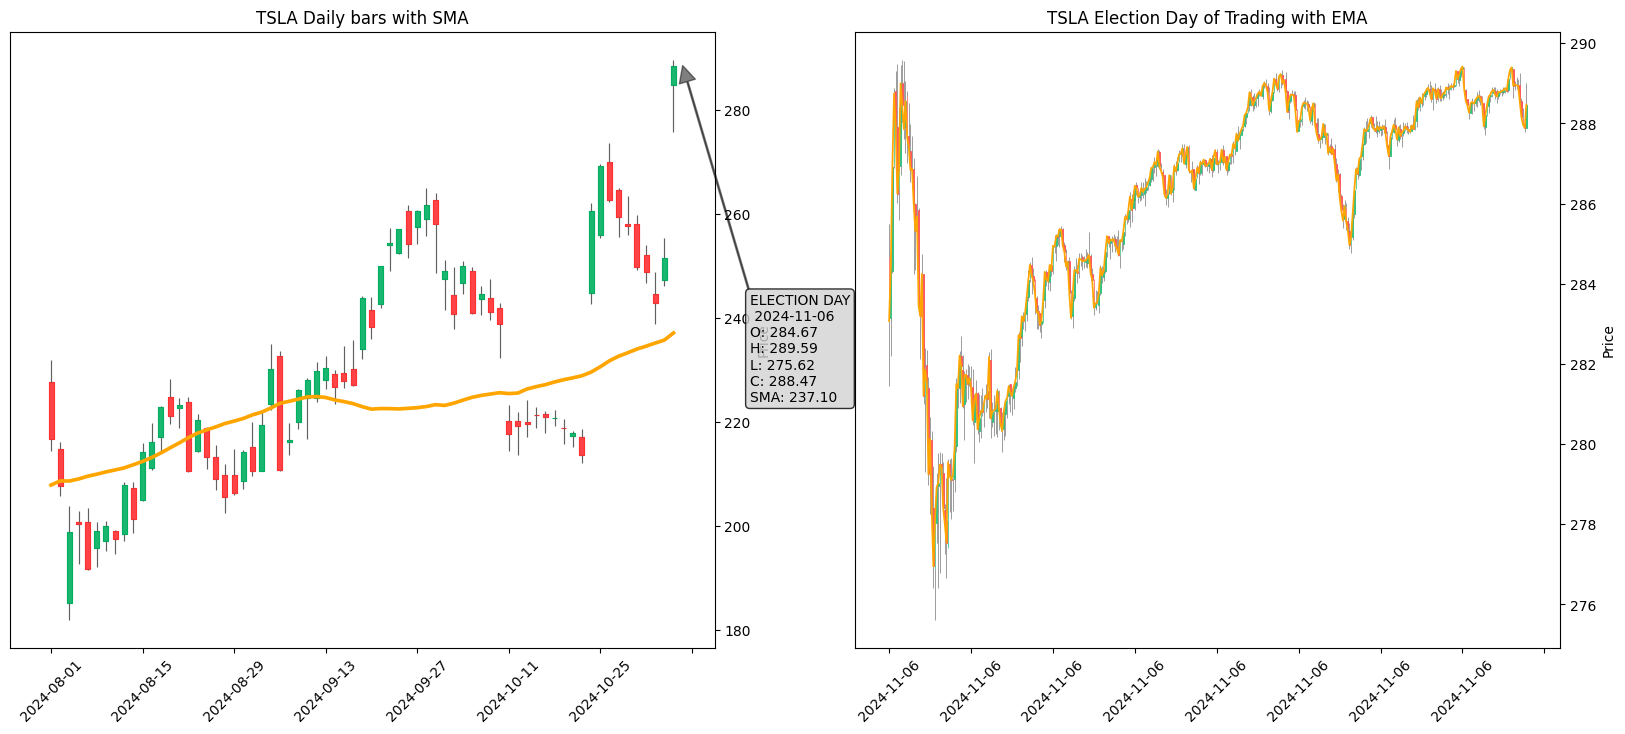

In [260]:
plot_ticker("TSLA")

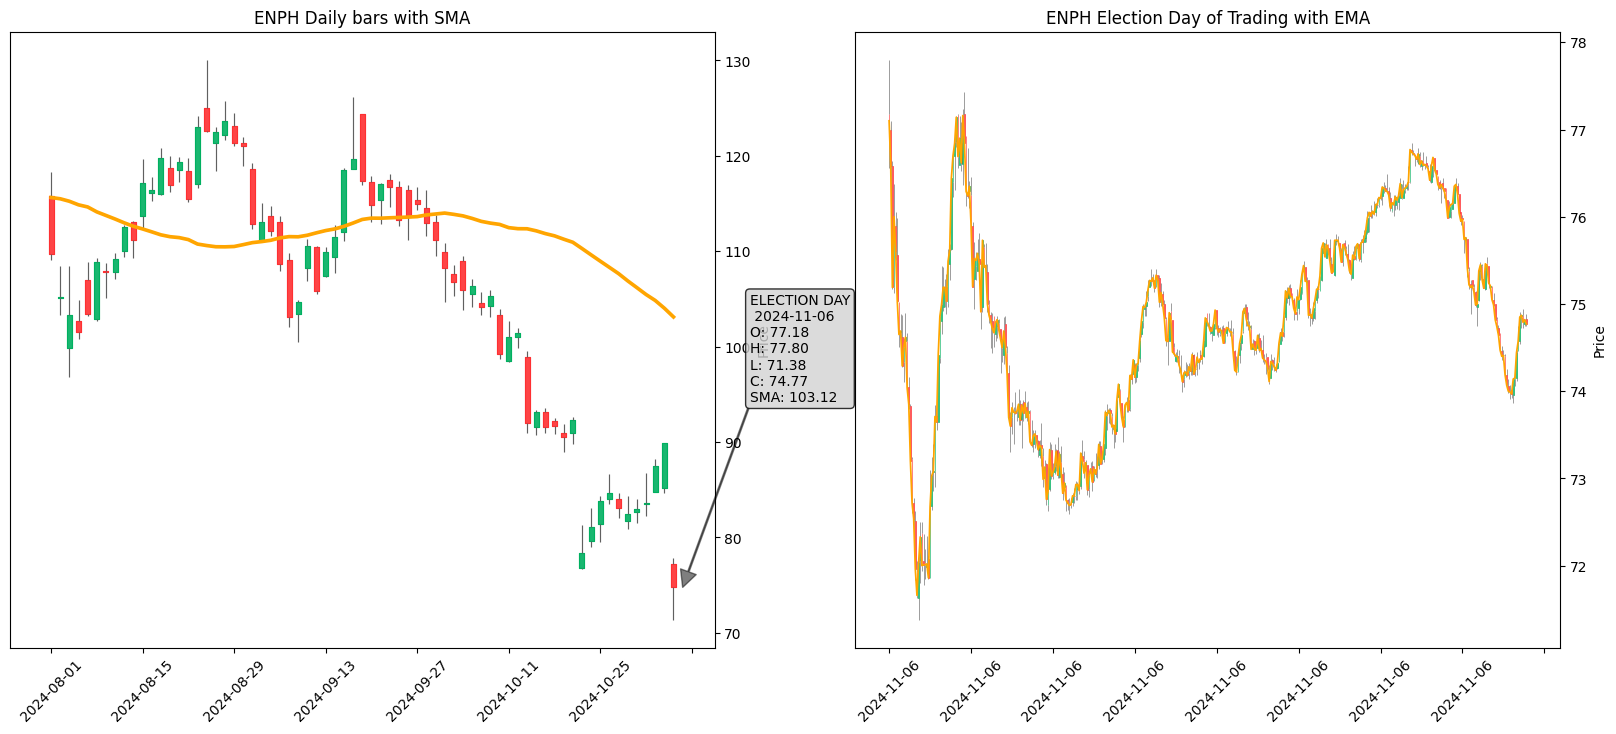

In [261]:
plot_ticker("ENPH")

In [274]:
def historic_resistances(
    df,
    symbol,
    current_date,
    peak_rank_w_pct=0.03,
    strong_peak_prominence_pct=0.05,
    strong_peak_distance=10,
    peak_distance=5,
):
    """
    Find historical resistance levels using peak detection

    Args:
        df: DataFrame with OHLC data
        symbol: Stock symbol
        current_date: Date to calculate resistances for
        peak_rank_w_pct: Percentage window to group nearby peaks
        strong_peak_prominence_pct: Minimum prominence for strong peaks as percentage
        strong_peak_distance: Minimum distance between strong peaks
        peak_distance: Minimum distance between regular peaks

    Returns:
        list: Resistance price levels sorted from strongest to weakest
    """
    # Convert current_date to pandas Timestamp if it isn't already
    current_date = pd.to_datetime(current_date)

    # Get historical data up to current date
    hist_data = df[(df["ticker"] == symbol) & (df.datetime <= current_date)]
    if len(hist_data) < peak_distance:
        return [0]

    # Get price data for peak detection
    prices = hist_data["high"].values

    # Find strong peaks first
    strong_prominence = np.mean(prices) * strong_peak_prominence_pct
    peaks, _ = find_peaks(
        prices, distance=strong_peak_distance, prominence=strong_prominence
    )

    # If not enough strong peaks found, find regular peaks
    if len(peaks) < 2:
        peaks, _ = find_peaks(prices, distance=peak_distance)

    if len(peaks) == 0:
        return [0]

    # Get peak prices
    peak_prices = prices[peaks]

    # Group nearby peaks
    grouped_peaks = []
    current_group = [peak_prices[0]]

    for price in peak_prices[1:]:
        if abs(price - np.mean(current_group)) / price <= peak_rank_w_pct:
            current_group.append(price)
        else:
            grouped_peaks.append(np.mean(current_group))
            current_group = [price]

    grouped_peaks.append(np.mean(current_group))

    # Sort resistance levels from highest to lowest
    resistance_levels = sorted(grouped_peaks, reverse=True)

    return resistance_levels


def historic_supports(
    df,
    symbol,
    current_date,
    trough_rank_w_pct=0.03,
    strong_trough_prominence_pct=0.05,
    strong_trough_distance=10,
    trough_distance=5,
):
    """
    Find historical support levels using trough detection

    Args:
        df: DataFrame with OHLC data
        symbol: Stock symbol
        current_date: Date to calculate supports for
        trough_rank_w_pct: Percentage window to group nearby troughs
        strong_trough_prominence_pct: Minimum prominence for strong troughs as percentage
        strong_trough_distance: Minimum distance between strong troughs
        trough_distance: Minimum distance between regular troughs

    Returns:
        list: Support price levels sorted from lowest to highest
    """
    # Convert current_date to pandas Timestamp if it isn't already
    current_date = pd.to_datetime(current_date)

    # Get historical data up to current date
    hist_data = df[(df["ticker"] == symbol) & (df.datetime <= current_date)]
    if len(hist_data) < trough_distance:
        return [0]

    # Get price data for trough detection
    prices = hist_data["low"].values

    # Find troughs by inverting the price series and finding peaks
    inverted_prices = -prices
    strong_prominence = np.mean(prices) * strong_trough_prominence_pct
    troughs, _ = find_peaks(
        inverted_prices, distance=strong_trough_distance, prominence=strong_prominence
    )

    # If not enough strong troughs found, find regular troughs
    if len(troughs) < 2:
        troughs, _ = find_peaks(inverted_prices, distance=trough_distance)

    if len(troughs) == 0:
        return [0]

    # Get trough prices
    trough_prices = prices[troughs]

    # Group nearby troughs
    grouped_troughs = []
    current_group = [trough_prices[0]]

    for price in trough_prices[1:]:
        if abs(price - np.mean(current_group)) / price <= trough_rank_w_pct:
            current_group.append(price)
        else:
            grouped_troughs.append(np.mean(current_group))
            current_group = [price]

    grouped_troughs.append(np.mean(current_group))

    # Sort support levels from lowest to highest
    support_levels = sorted(grouped_troughs)

    return support_levels

In [284]:
# resistances column holds the resistance levels (from the past) for each day
df_daily["resistances"] = df_daily.progress_apply(
    lambda x: historic_resistances(
        df_daily,
        x["ticker"],
        x["date"],
        peak_rank_w_pct=0.03,  # group peaks that are within 3% of the stock price
        strong_peak_prominence_pct=0.05,  # strong peaks have a prominence of at least 5%
        strong_peak_distance=10,  # strong peaks are at least 10 bars away from each other
        peak_distance=5,  # peaks are at least 5 bars away from each other
    ),
    axis=1,
)
df_daily["supports"] = df_daily.progress_apply(
    lambda x: historic_supports(
        df_daily,
        x["ticker"],
        x["date"],
        trough_rank_w_pct=0.03,
        strong_trough_prominence_pct=0.05,
        strong_trough_distance=10,
        trough_distance=5,
    ),
    axis=1,
)
df_daily["resistances"] = df_daily.apply(
    lambda row: row["resistances"] if row["resistances"][0] > 0 else [], axis=1
)
df_daily["supports"] = df_daily.apply(
    lambda row: row["supports"] if row["supports"][0] > 0 else [], axis=1
)

100%|██████████| 8638/8638 [00:08<00:00, 1070.67it/s]


In [285]:
df_daily_backup = df_daily.copy()

In [289]:
def plot_with_resistances_and_supports(df, ax):
    # Convert date column to datetime if it's not already
    df["datetime"] = pd.to_datetime(df["datetime"])
    
    # Set datetime as index and ensure it's DatetimeIndex
    df = df.set_index("datetime")
    
    # Create a list to hold resistance line data
    addplot = []

    last_resistances = df.iloc[-1]["resistances"]
    last_supports = df.iloc[-1]["supports"]
    for resistance in last_resistances:
        addplot.append(mpf.make_addplot([resistance] * len(df), color="red", ax=ax))
    for support in last_supports:
        addplot.append(mpf.make_addplot([support] * len(df), color="green", ax=ax))

    # Plot the candlestick chart with resistance lines
    mpf.plot(df, type="candle", addplot=addplot, style="charles", volume=False, ax=ax)

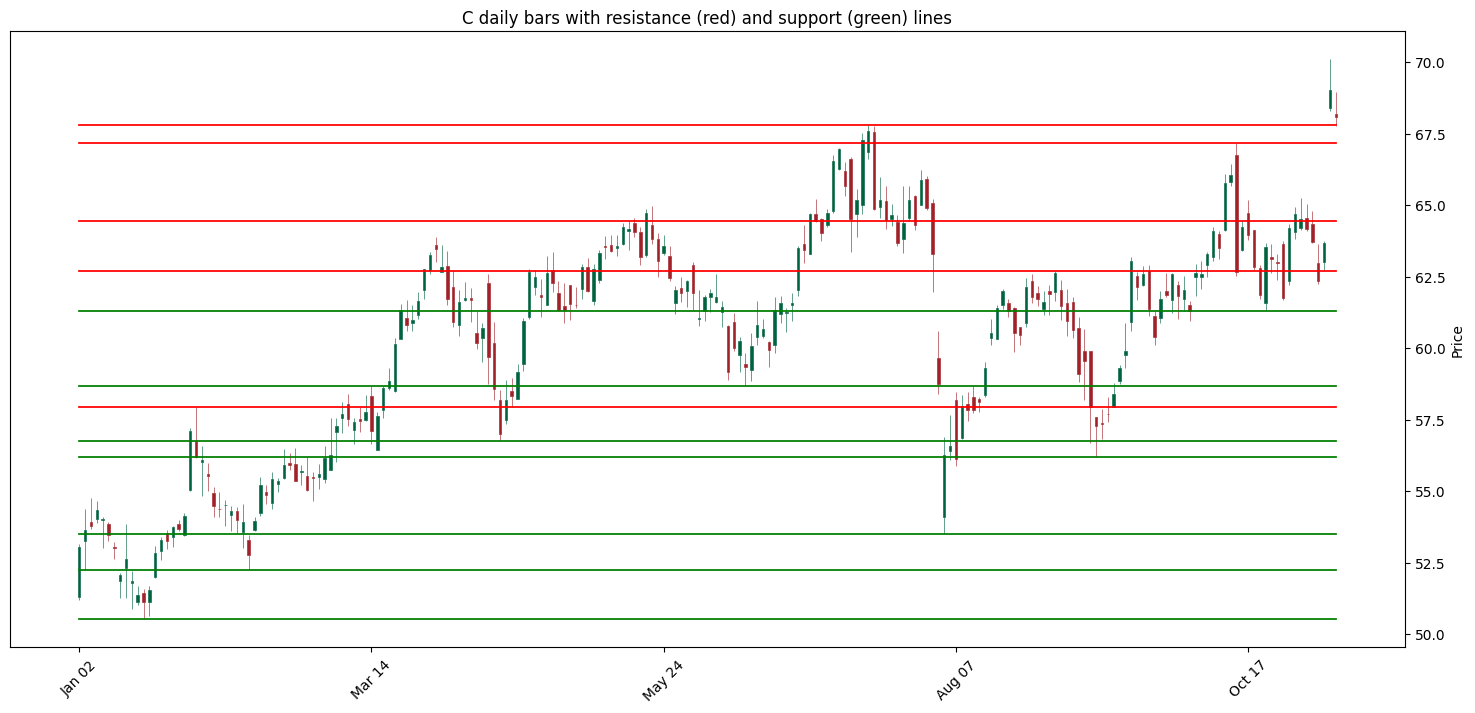

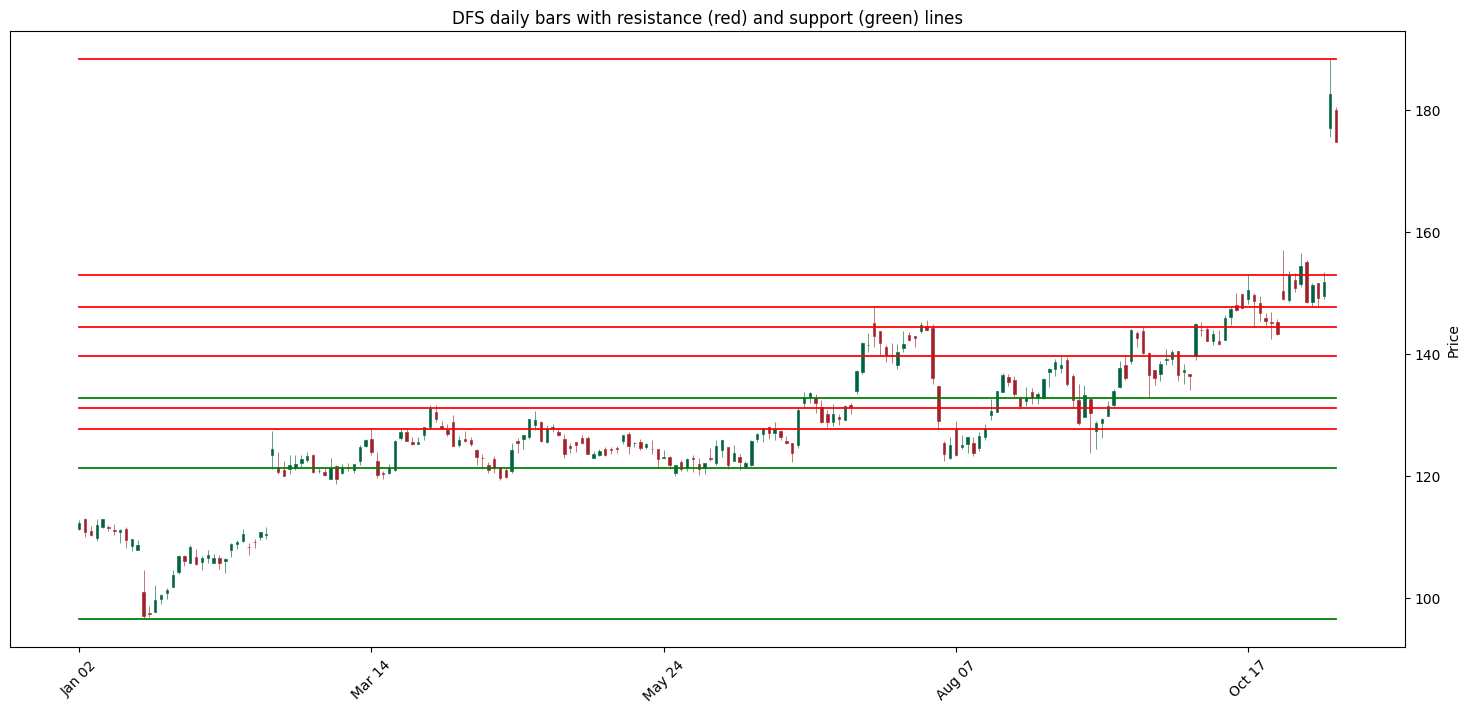

In [290]:
# plotting support and resistance for stocks
symbols = df_daily.sample(2)["ticker"].values  # sample 2 stock symbols
for symbol in symbols:
    daily = df_daily[df_daily["ticker"] == symbol]
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.set_title(f"{symbol} daily bars with resistance (red) and support (green) lines")
    plot_with_resistances_and_supports(daily, ax)

In [293]:
def create_time_idx(group):
    # Use pd.factorize to create a continuous index for each symbol's time series
    group["time_idx"] = pd.factorize(group.index)[0]
    return group


df_index = df.index
df = (
    df.groupby("ticker")
    .apply(create_time_idx)
    .reset_index(drop=True)
    .set_index(df_index)
)
print(df.shape)
df.head()

(8638, 11)


,open,high,low,close,ticker,datetime,date,SMA,resistances,supports,time_idx
0,19.14,19.53,19.000,19.35,AES,2024-01-02,2024-01-02,19.3500,[],[],0
1,19.11,19.16,18.570,18.93,AES,2024-01-03,2024-01-03,19.1400,[],[],1
2,19.09,19.13,18.745,18.87,AES,2024-01-04,2024-01-04,19.0500,[],[],2
3,18.80,19.35,18.630,18.80,AES,2024-01-05,2024-01-05,18.9875,[],[],3
4,18.69,19.24,18.690,19.07,AES,2024-01-08,2024-01-08,19.0040,[19.35],[18.57],4


In [294]:
df["close_rank"] = (df["close"] - df["low"]) / (
    df["high"] - df["low"]
)  # rank of the close price in the daily range
df["log_return"] = (
    np.log(df.groupby("ticker")["close"].pct_change() + 1) * 100
)  # transform close prices to log returns
df["log_return"] = df["log_return"].fillna(0)  # fill NaNs with 0
df.head()

,open,high,low,close,ticker,datetime,date,SMA,resistances,supports,time_idx,close_rank,log_return
0,19.14,19.53,19.000,19.35,AES,2024-01-02,2024-01-02,19.3500,[],[],0,0.660377,0.000000
1,19.11,19.16,18.570,18.93,AES,2024-01-03,2024-01-03,19.1400,[],[],1,0.610169,-2.194445
2,19.09,19.13,18.745,18.87,AES,2024-01-04,2024-01-04,19.0500,[],[],2,0.324675,-0.317461
3,18.80,19.35,18.630,18.80,AES,2024-01-05,2024-01-05,18.9875,[],[],3,0.236111,-0.371649
4,18.69,19.24,18.690,19.07,AES,2024-01-08,2024-01-08,19.0040,[19.35],[18.57],4,0.690909,1.425955


In [295]:
sp500 = pd.read_csv("../data/US/sp500.csv")
sp500.head()

,symbol,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded
0,TPL,Texas Pacific Land Corporation,Energy,Oil & Gas Exploration & Production,"Dallas, Texas",2024-11-26,1811074,1888
1,AMTM,Amentum,Industrials,Diversified Support Services,"Chantilly, Virginia",2024-09-30,2011286,2020
2,DELL,Dell Technologies,Information Technology,"Technology Hardware, Storage & Peripherals","Round Rock, Texas",2024-09-23,1571996,2016
3,ERIE,Erie Indemnity,Financials,Insurance Brokers,"Erie, Pennsylvania",2024-09-23,922621,1925
4,PLTR,Palantir Technologies,Information Technology,Internet Services & Infrastructure,"Denver, Colorado",2024-09-23,1321655,2003


In [296]:
# Create a dictionary mapping from symbol to sector
sector_map = dict(zip(sp500['symbol'], sp500['sector']))


In [298]:
# Assuming 'date' is your datetime column
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute

In [300]:
# process categorical variables
df["month"] = df["month"].astype(str).astype("category")
df["hour"] = df["hour"].astype(str).astype("category")
df["minute"] = df["minute"].astype(str).astype("category")
df['sector'] = df['ticker'].map(sector_map)
df["day_of_the_week"] = df["datetime"].dt.dayofweek.astype(str).astype("category")


# df["candidate"] = df["candidate"].astype(str).astype("category")
# df["confidence_level"] = df["confidence_level"].astype(str).astype("category")
# df["impact_strength"] = df["impact_strength"].astype(str).astype("category")
# df["sentiment"] = df["sentiment"].astype(str).astype("category")

df


,open,high,low,close,ticker,datetime,date,SMA,resistances,supports,time_idx,close_rank,log_return,month,day,hour,minute,sector,day_of_the_week
0,19.14,19.53,19.000,19.35,AES,2024-01-02,2024-01-02,19.3500,[],[],0,0.660377,0.000000,1,2,0,0,Utilities,1
1,19.11,19.16,18.570,18.93,AES,2024-01-03,2024-01-03,19.1400,[],[],1,0.610169,-2.194445,1,3,0,0,Utilities,2
2,19.09,19.13,18.745,18.87,AES,2024-01-04,2024-01-04,19.0500,[],[],2,0.324675,-0.317461,1,4,0,0,Utilities,3
3,18.80,19.35,18.630,18.80,AES,2024-01-05,2024-01-05,18.9875,[],[],3,0.236111,-0.371649,1,5,0,0,Utilities,4
4,18.69,19.24,18.690,19.07,AES,2024-01-08,2024-01-08,19.0040,[19.35],[18.57],4,0.690909,1.425955,1,8,0,0,Utilities,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8633,65.22,65.58,64.620,64.69,WFC,2024-11-01,2024-11-01,58.4652,"[61.57666666666666, 59.0, 51.44]","[46.785, 50.185, 55.965]",211,0.072917,-0.339506,11,1,0,0,Financials,4
8634,64.56,64.65,63.050,63.72,WFC,2024-11-04,2024-11-04,58.6062,"[61.57666666666666, 59.0, 51.44]","[46.785, 50.185, 55.965]",212,0.418750,-1.510815,11,4,0,0,Financials,0
8635,64.00,64.50,63.620,64.07,WFC,2024-11-05,2024-11-05,58.7530,"[61.57666666666666, 59.0, 51.44]","[46.785, 50.185, 55.965]",213,0.511364,0.547775,11,5,0,0,Financials,1
8636,73.30,74.27,69.950,72.53,WFC,2024-11-06,2024-11-06,59.0780,"[61.57666666666666, 59.0, 51.44]","[46.785, 50.185, 55.965]",214,0.597222,12.402403,11,6,0,0,Financials,2


In [301]:
# print("candidate -->", df_["candidate"].unique())
# print()
# print("confidence_level -->", df_["confidence_level"].unique())
# print()
# print("impact_strength -->", df_["impact_strength"].unique())
# print()
# print("sentiment -->", df_["sentiment"].unique())



In [307]:
START_FILTERING = "2024-08-31"
END_FILTERING = "2024-11-06"

df_ = df[df["datetime"] >= START_FILTERING]
df_ = df[df["datetime"] <= END_FILTERING]
print(df_.shape)
df_

(8598, 19)


,open,high,low,close,ticker,datetime,date,SMA,resistances,supports,time_idx,close_rank,log_return,month,day,hour,minute,sector,day_of_the_week
0,19.14,19.53,19.000,19.35,AES,2024-01-02,2024-01-02,19.3500,[],[],0,0.660377,0.000000,1,2,0,0,Utilities,1
1,19.11,19.16,18.570,18.93,AES,2024-01-03,2024-01-03,19.1400,[],[],1,0.610169,-2.194445,1,3,0,0,Utilities,2
2,19.09,19.13,18.745,18.87,AES,2024-01-04,2024-01-04,19.0500,[],[],2,0.324675,-0.317461,1,4,0,0,Utilities,3
3,18.80,19.35,18.630,18.80,AES,2024-01-05,2024-01-05,18.9875,[],[],3,0.236111,-0.371649,1,5,0,0,Utilities,4
4,18.69,19.24,18.690,19.07,AES,2024-01-08,2024-01-08,19.0040,[19.35],[18.57],4,0.690909,1.425955,1,8,0,0,Utilities,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8632,65.10,65.75,64.630,64.91,WFC,2024-10-31,2024-10-31,58.2912,"[61.57666666666666, 59.0, 51.44]","[46.785, 50.185, 55.965]",210,0.250000,-0.813200,10,31,0,0,Financials,3
8633,65.22,65.58,64.620,64.69,WFC,2024-11-01,2024-11-01,58.4652,"[61.57666666666666, 59.0, 51.44]","[46.785, 50.185, 55.965]",211,0.072917,-0.339506,11,1,0,0,Financials,4
8634,64.56,64.65,63.050,63.72,WFC,2024-11-04,2024-11-04,58.6062,"[61.57666666666666, 59.0, 51.44]","[46.785, 50.185, 55.965]",212,0.418750,-1.510815,11,4,0,0,Financials,0
8635,64.00,64.50,63.620,64.07,WFC,2024-11-05,2024-11-05,58.7530,"[61.57666666666666, 59.0, 51.44]","[46.785, 50.185, 55.965]",213,0.511364,0.547775,11,5,0,0,Financials,1


In [101]:
TRAIN_PERIOD_END = "2024-10-10"
VAL_PERIOD_END = "2024-11-05"

In [102]:
df_train = df_[df_["date"] < TRAIN_PERIOD_END]
df_val = df_[(df_["date"] >= TRAIN_PERIOD_END) & (df_["date"] < VAL_PERIOD_END)]
df_test = df_[df_["date"] >= VAL_PERIOD_END]
print(
    f"Total train rows: {len(df_train)}, Total validation rows: {len(df_val)}, Total test rows: {len(df_test)}"
)
print("Rows match?", len(df_train) + len(df_val) + len(df_test) == len(df_))

Total train rows: 47970, Total validation rows: 15210, Total test rows: 8190
Rows match? True


In [103]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

In [116]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import numpy as np

# Create NaNLabelEncoder for each categorical variable
categorical_encoders = {
    "candidate": NaNLabelEncoder(add_nan=True).fit(np.array(["-1", "0", "1"])),
    "confidence_level": NaNLabelEncoder(add_nan=True).fit(np.array(["-1", "2", "3", "4"])),
    "impact_strength": NaNLabelEncoder(add_nan=True).fit(np.array(["-1", "2", "3", "4"])),
    "sentiment": NaNLabelEncoder(add_nan=True).fit(np.array(["-1", "0", "1"])),
    "day_of_the_week": NaNLabelEncoder(add_nan=True).fit(np.array([str(i) for i in range(7)])),
    "hour": NaNLabelEncoder(add_nan=True).fit(np.array([str(i) for i in range(24)])),
    "minute": NaNLabelEncoder(add_nan=True).fit(np.array([str(i) for i in range(60)])),
    "sector": NaNLabelEncoder(add_nan=True).fit(df_["sector"].unique()),  # Add sector encoder
}

training_dataset = TimeSeriesDataSet(
    df_train.reset_index(),
    time_idx="time_idx",
    target="log_return",
    group_ids=["ticker"],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=[
        "time_idx",
        "volume",
    ],
    time_varying_known_categoricals=[
        "day_of_the_week",
        "hour",
        "minute",
        "candidate",
        "confidence_level",
        "impact_strength",
        "sentiment",
    ],
    categorical_encoders=categorical_encoders,
    time_varying_unknown_reals=[
        "close_rank",
        "open",
        "high",
        "low",
        "close",
        "EMA",
    ],
    static_categoricals=["sector"],
    static_reals=[],
    add_relative_time_idx=True,
    add_encoder_length=False,
    target_normalizer=None,
)

In [119]:
# Create validation dataset using the same parameters as training
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, df_val.reset_index(), predict=True, stop_randomization=True
)

# Create test dataset using the same parameters as training
test_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, df_test.reset_index(), predict=True, stop_randomization=True
)

# Create data loaders for model training
batch_size = 128
train_dataloader = training_dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation_dataset.to_dataloader(
    train=False, batch_size=batch_size * 2, num_workers=0
)
test_dataloader = test_dataset.to_dataloader(
    train=False, batch_size=batch_size * 2, num_workers=0
)

# Create baseline model for comparison
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
# Extract the actual target values from the tuple
actuals = baseline_predictions.y[0]  # Get first element of tuple
print(f"Baseline MAE: {(baseline_predictions.output - actuals).abs().mean()}")

# Set up trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    gradient_clip_val=0.1,
    limit_train_batches=50,  # comment in for training, running valiation every 50 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[
        pl.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
        ),
        pl.callbacks.LearningRateMonitor("epoch"),
    ],
)

# Create the TFT model
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# Fit the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# Load the best model
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_sel

Baseline MAE: 0.11546313017606735
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]

Epoch 9: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s, v_num=5, train_loss_step=0.0351, val_loss=0.027, train_loss_epoch=0.0335] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s, v_num=5, train_loss_step=0.0351, val_loss=0.027, train_loss_epoch=0.0335]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'time_idx': <Figure size 1000x500 with 2 Axes>,
 'volume': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'close_rank': <Figure size 1000x500 with 2 Axes>,
 'open': <Figure size 1000x500 with 2 Axes>,
 'high': <Figure size 1000x500 with 2 Axes>,
 'low': <Figure size 1000x500 with 2 Axes>,
 'close': <Figure size 1000x500 with 2 Axes>,
 'EMA': <Figure size 1000x500 with 2 Axes>,
 'sector': <Figure size 640x480 with 2 Axes>,
 'day_of_the_week': <Figure size 640x480 with 2 Axes>,
 'hour': <Figure size 1000x500 with 2 Axes>,
 'minute': <Figure size 1000x500 with 2 Axes>,
 'candidate': <Figure size 640x480 with 2 Axes>,
 'confidence_level': <Figure size 640x480 with 2 Axes>,
 'impact_strength': <Figure size 640x480 with 2 Axes>,
 'sentiment': <Figure size 640x480 with 2 Axes>}

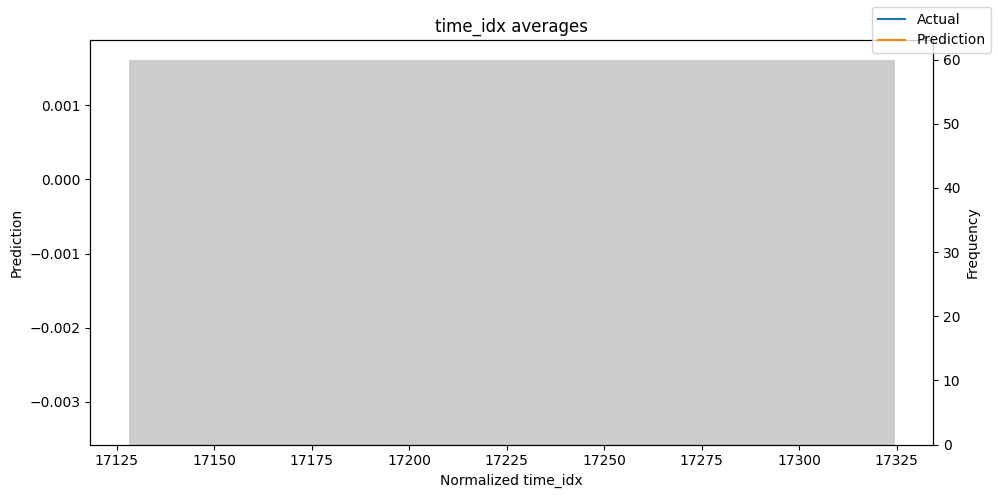

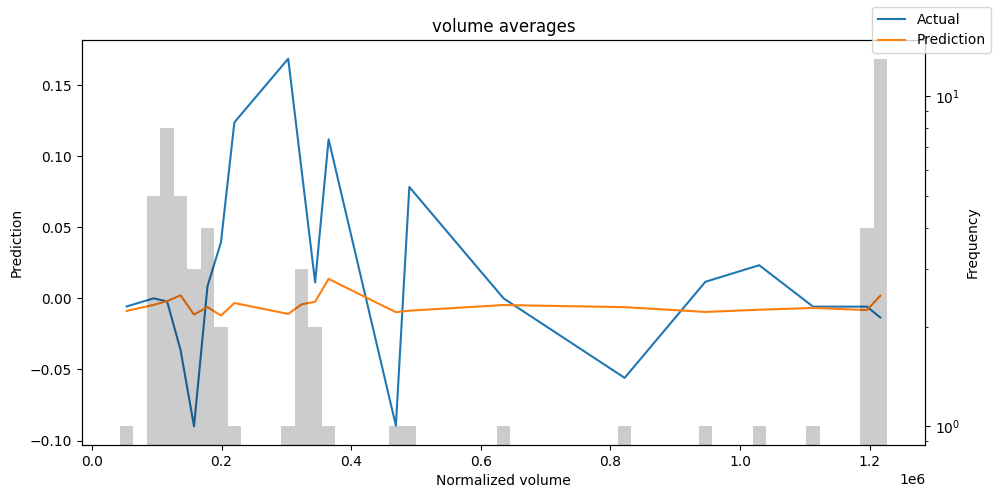

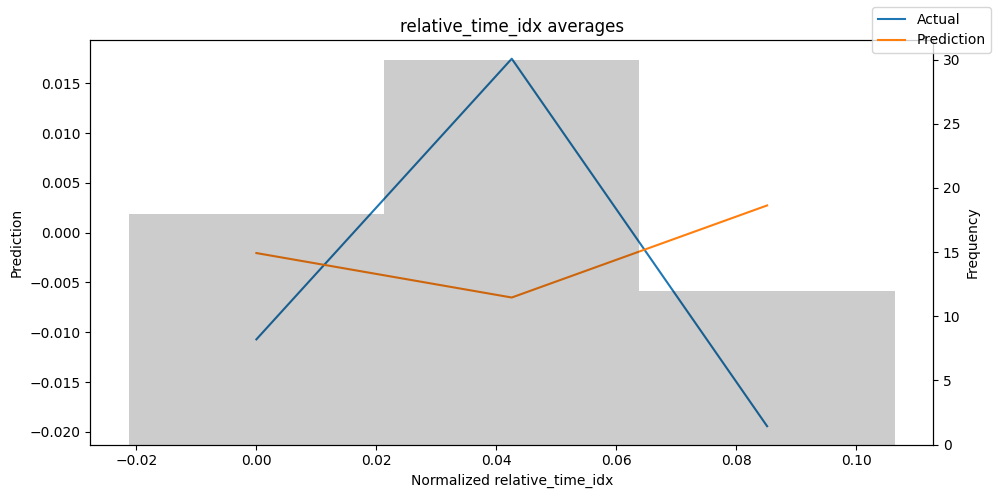

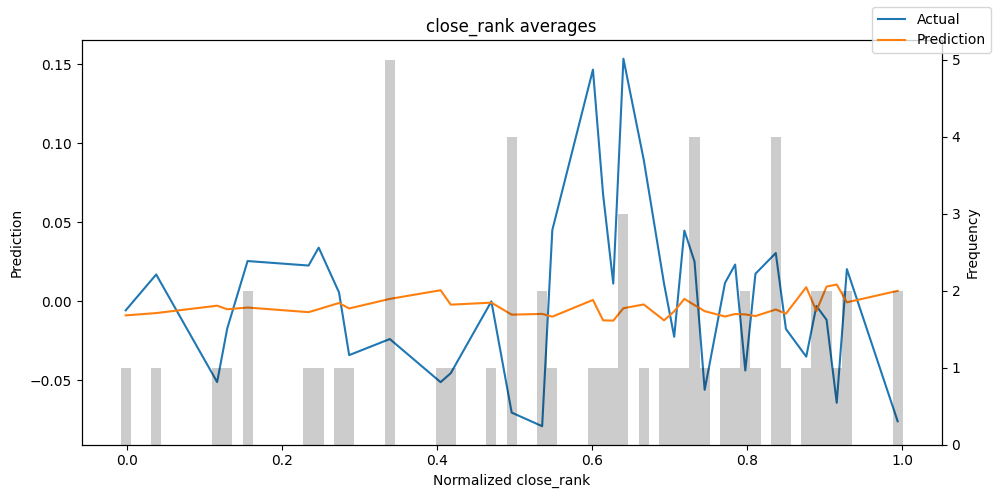

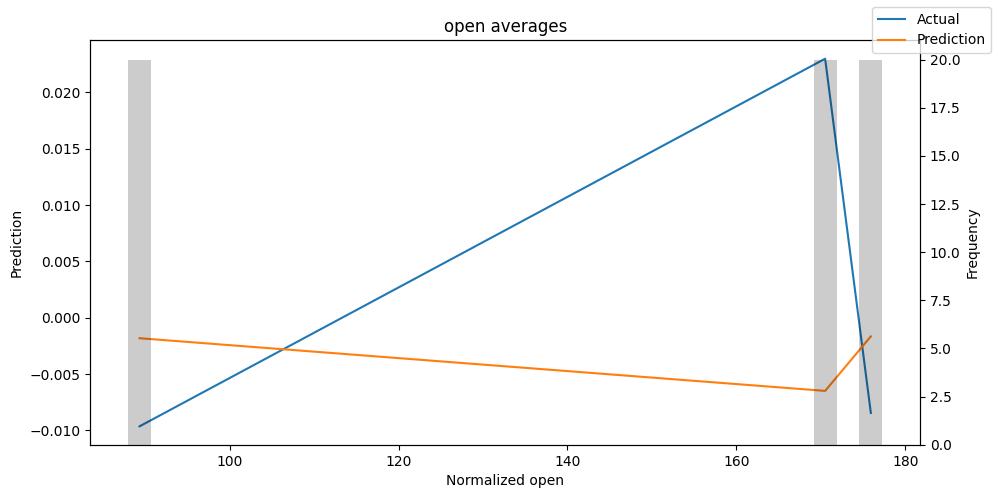

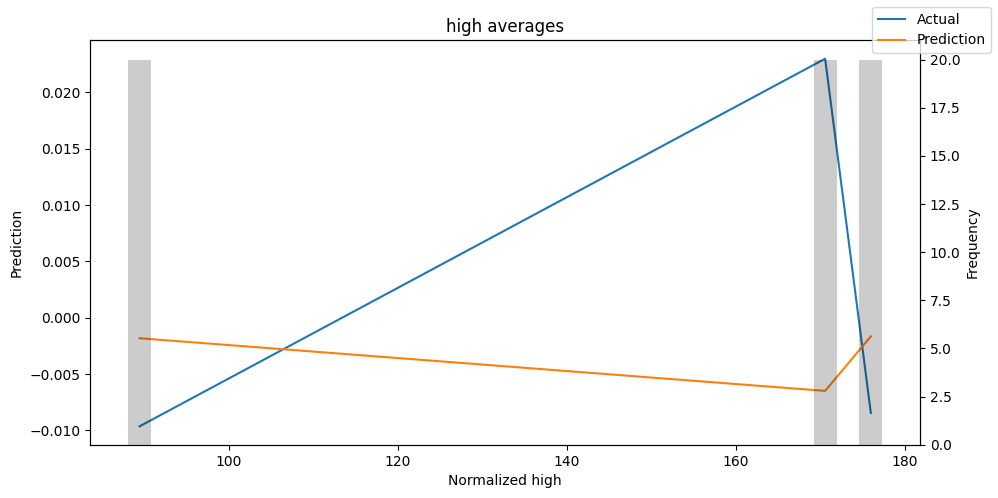

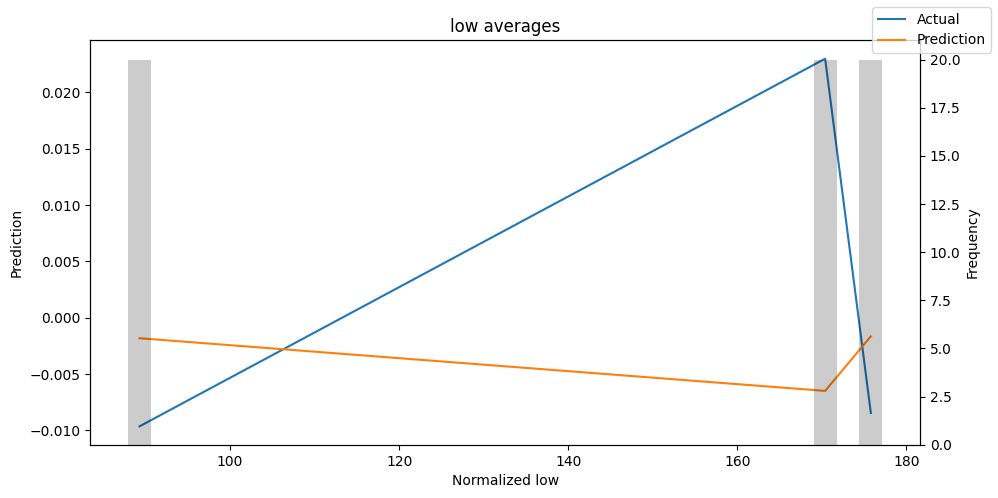

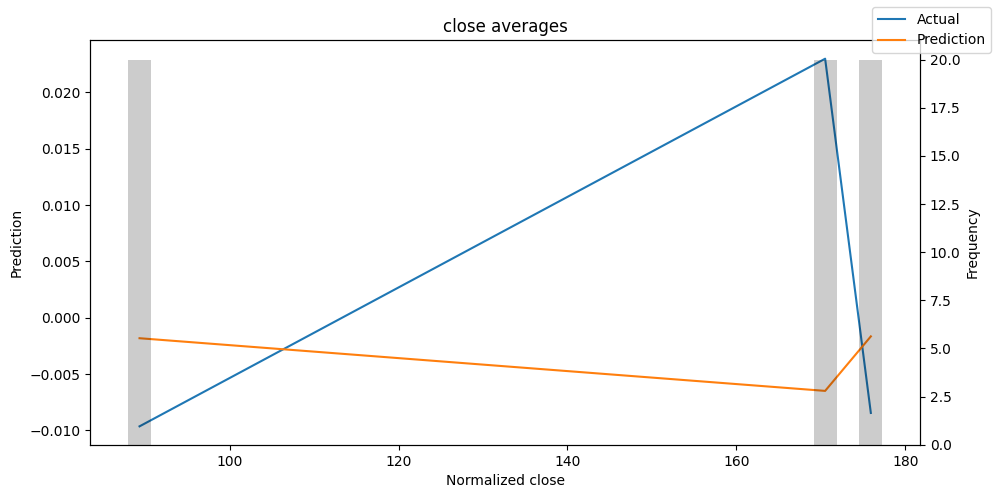

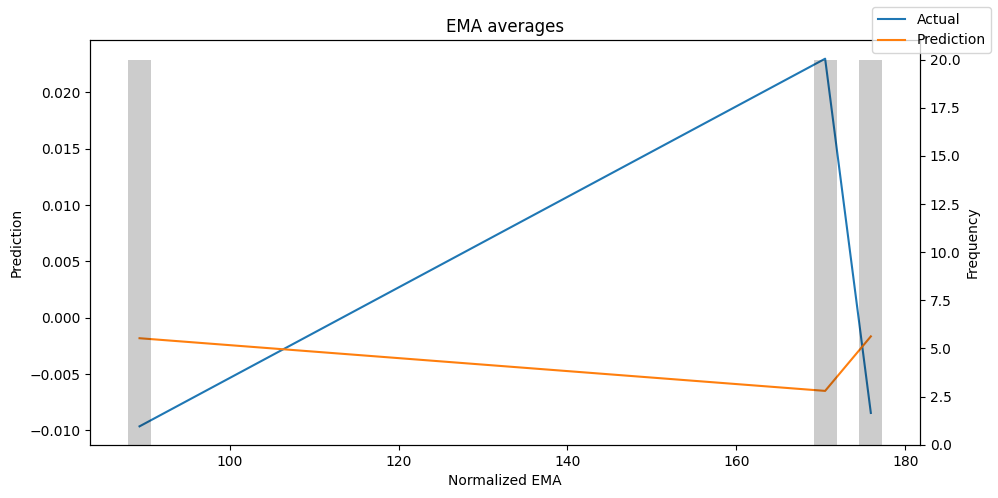

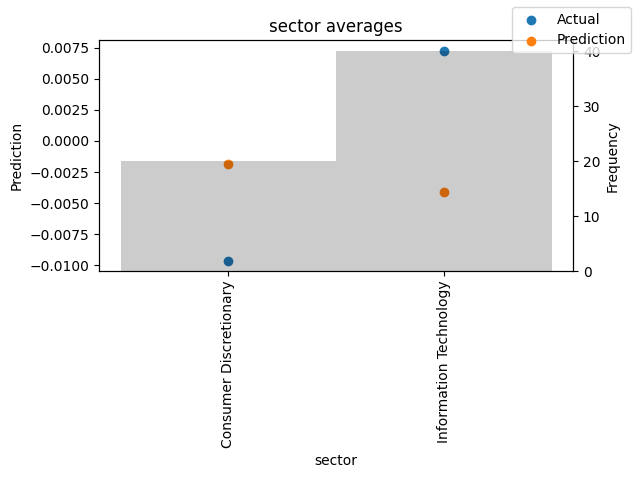

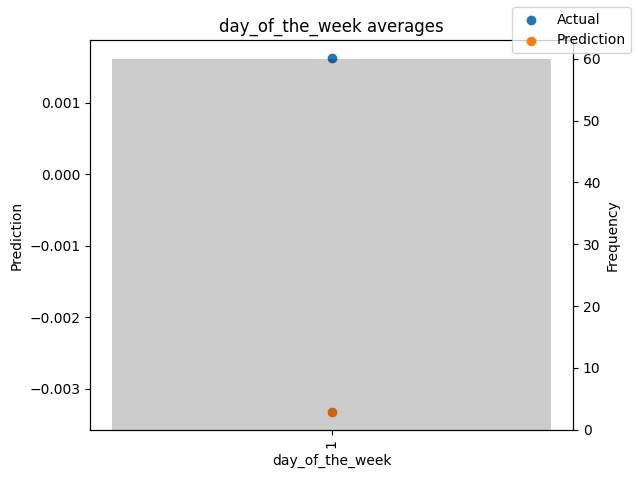

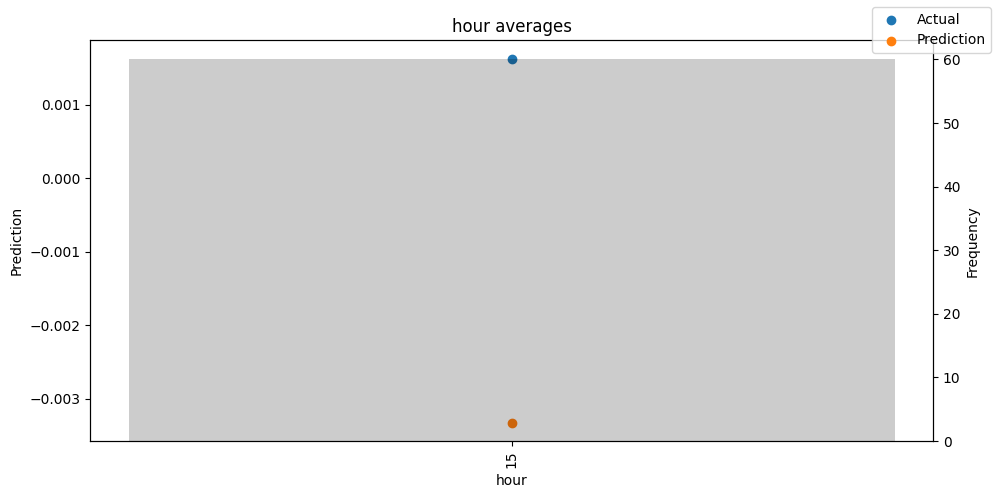

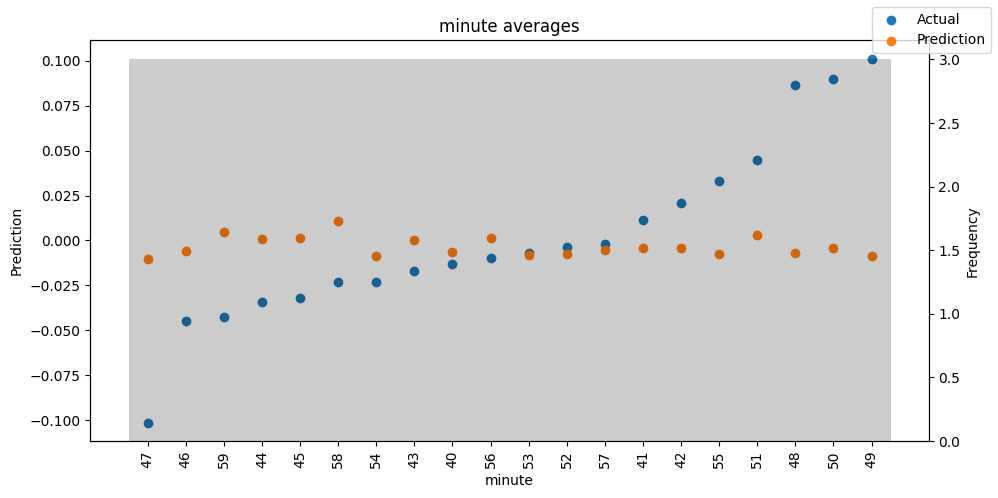

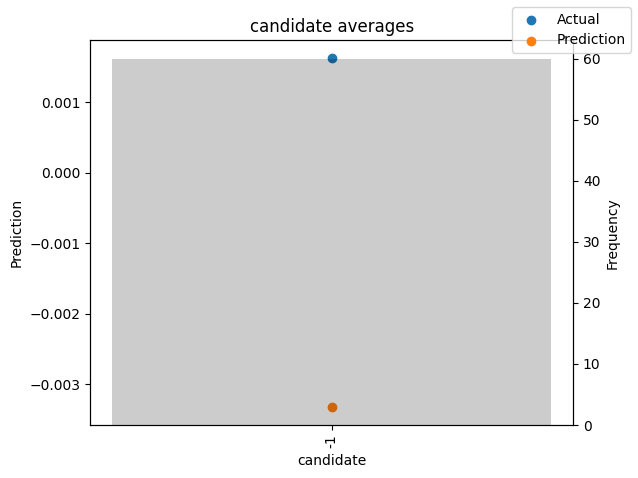

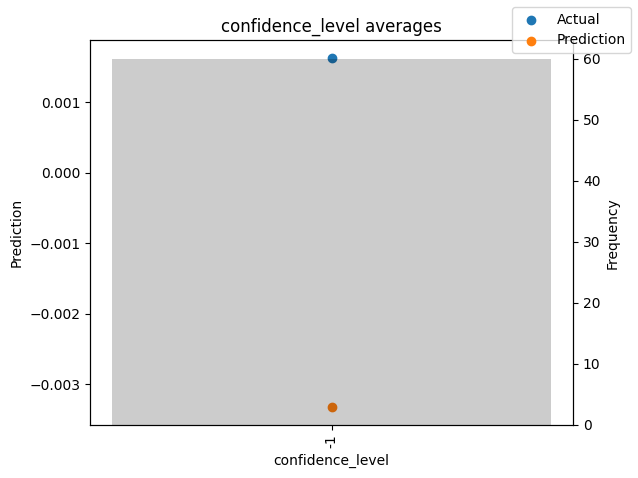

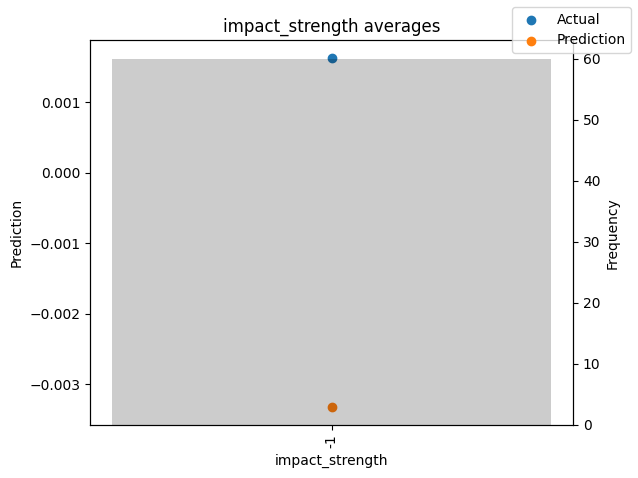

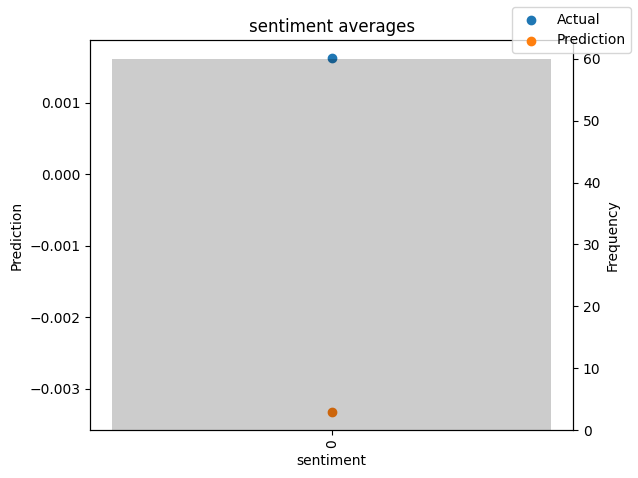

In [120]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [121]:
# Make predictions
predictions = best_tft.predict(test_dataloader, return_y=True)
# Extract the actual values from the tuple
actuals = predictions.y[0]  # Get first element of tuple
print(f"Test MAE: {(predictions.output - actuals).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test MAE: 0.04988733306527138
